# importing the necessary libraries

In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, MaxPooling2D, Dropout,InputLayer, Flatten,BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy

### Loading and splitting the data 

In [2]:
dataset, info = tfds.load('malaria',shuffle_files=True, with_info=True,as_supervised = True, split = ['train'])

In [3]:
training_dataset, validation_dataset, testing_dataset = tfds.load('malaria',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True)

In [4]:
training_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [5]:
testing_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

# Data visualization

(-0.5, 147.5, 159.5, -0.5)

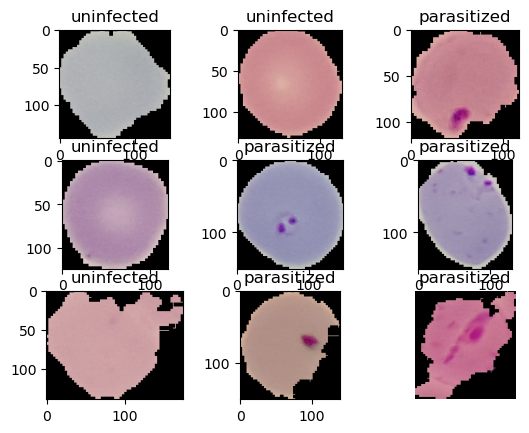

In [6]:
for i, (image, label) in enumerate(training_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(info.features['label'].int2str(label))
plt.axis('off')


We can see that parasitized cells have some pigments while uninfected cells lack those pigments. 

In [7]:
display(info.features['label'].int2str(1))
display(info.features['label'].int2str(0))

'uninfected'

'parasitized'

# Data Preprocessing:

In [8]:
IMAGE_SIZE = 150
def resize_rescale(image, label):
  return tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))/255.0, label

In [9]:
train_dataset =  training_dataset.map(resize_rescale)
val_dataset =  validation_dataset.map(resize_rescale)
test_dataset = testing_dataset.map(resize_rescale)
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [11]:
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Creating the tensorflow model

In [12]:
model_cnn = tf.keras.Sequential([
    InputLayer(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)),
    Conv2D(filters=6, kernel_size=6, strides=1, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',activation='relu'),
    BatchNormalization(),
    MaxPool2D (pool_size = 2, strides = 2),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),

    Dense(10, activation='relu'),
    BatchNormalization(),

    Dense(1, activation='sigmoid'),

])

model_cnn.summary()


C:\Users\PC\anaconda3-2\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 145, 145, 6)         │             654 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 145, 145, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 72, 72, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 70, 70, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 70, 70, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 35, 35, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 19600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       1,960,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,963,183 (7.49 MB)

 Trainable params: 1,962,919 (7.49 MB)

 Non-trainable params: 264 (1.03 KB)

In [18]:
model_cnn.compile(loss='binary_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

In [19]:
history = model_cnn.fit(train_dataset, validation_data=val_dataset, epochs = 20, verbose = 1)

Epoch 1/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 167s 264ms/step - accuracy: 0.6520 - loss: 0.6490 - val_accuracy: 0.5219 - val_loss: 0.9155
Epoch 2/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 203s 336ms/step - accuracy: 0.8898 - loss: 0.2735 - val_accuracy: 0.6426 - val_loss: 0.7458
Epoch 3/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 214s 354ms/step - accuracy: 0.9387 - loss: 0.1752 - val_accuracy: 0.9436 - val_loss: 0.1595
Epoch 4/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 190s 315ms/step - accuracy: 0.9510 - loss: 0.1367 - val_accuracy: 0.8609 - val_loss: 0.3218
Epoch 5/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 205s 339ms/step - accuracy: 0.9530 - loss: 0.1286 - val_accuracy: 0.9429 - val_loss: 0.1774
Epoch 6/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 206s 342ms/step - accuracy: 0.9645 - loss: 0.0977 - val_accuracy: 0.9310 - val_loss: 0.2025
Epoch 7/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 213s 353ms/step - accuracy: 0.9726 - loss: 0.0779 - val_accuracy: 0.9163 - val_loss: 0.2448
Epoch 8/20
603/603 ━━━━━━━━━━━━━━━━━━━━ 206s 341ms/step - accuracy: 0.9804 -

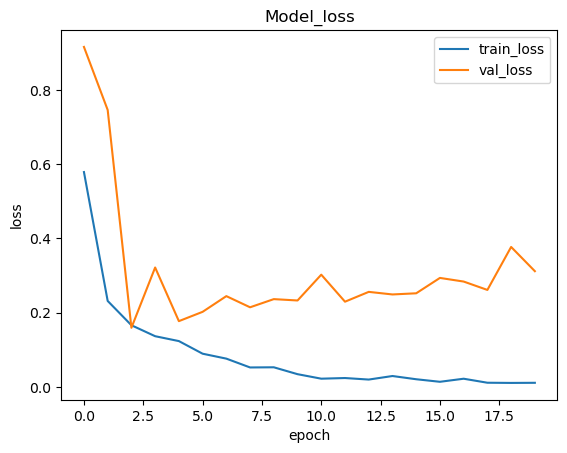

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

From the plot above, we can see that we could be having an overfitting problem. A look at the plot shows that after 2 epochs, the validation loss increases while the training loss keeps declining. This suggests that the model might not generalize well to the unseen data (testing dataset).

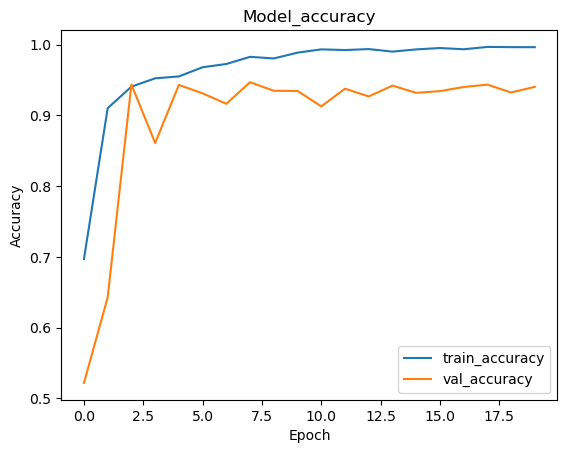

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

The accuracy plot follows a similar trend like the model loss plot. After 2 epochs, the accuracy plot increases slightly to almost 100% while the validation accuracy is levelling off. 

# Model Evaluation and Testing

In [22]:
test_dataset = test_dataset.batch(1)

In [23]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [26]:
model_cnn.evaluate(test_dataset)

4134/4134 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.9346 - loss: 0.3789


[0.34428122639656067, 0.9366230964660645]

When shown the training data, the model has 93.46% accuracy. This means that the model's success rate is 93.46%. 

In [41]:
#saving the model
model_cnn.save ("malaria_model.keras")